In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import re
import nltk
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\april\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\april\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\april\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
def read_dataframe(tsv_file: str) -> pd.DataFrame:
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    df.fillna("", inplace=True)
    df.columns = ['id', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title',
                 'state_info', 'party_affiliation', 'count_1', 'count_2', 'count_3',
                 'count_4', 'count_5', 'context']
    return df

df_train = read_dataframe('train.tsv')
df_test = read_dataframe('test.tsv')

In [24]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_and_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join(lemmatizer.lemmatize(token) for token in tokens)

def preprocess_statement(statement):
    cleaned_text = clean_text(statement)
    return tokenize_and_lemmatize(cleaned_text)

def convert_to_binary_label(label):
    label = str(label).lower()
    return 'true' if label in ['true', 'mostly-true', 'half-true', 'barely-true'] else 'false'

df_train['bi_label'] = df_train['label'].apply(convert_to_binary_label)
df_test['bi_label'] = df_test['label'].apply(convert_to_binary_label)

label_mapping = {'false': 0, 'true': 1}
df_train['encoded_label'] = df_train['bi_label'].map(label_mapping)
df_test['encoded_label'] = df_test['bi_label'].map(label_mapping)

df_train['processed_statement'] = df_train['statement'].apply(preprocess_statement)
df_test['processed_statement'] = df_test['statement'].apply(preprocess_statement)

# Data Splitting and Preprocessing

In [25]:
# Load validation data
df_valid = read_dataframe('valid.tsv')

# Apply binary label conversion to validation data
df_valid['bi_label'] = df_valid['label'].apply(convert_to_binary_label)
df_valid['encoded_label'] = df_valid['bi_label'].map(label_mapping)

# Process statements for all datasets
print("Processing training data...")
df_train['processed_statement'] = df_train['statement'].apply(preprocess_statement)

print("Processing validation data...")
df_valid['processed_statement'] = df_valid['statement'].apply(preprocess_statement)

print("Processing test data...")
df_test['processed_statement'] = df_test['statement'].apply(preprocess_statement)

# Split training data into train and validation sets
X = df_train['processed_statement']
y = df_train['encoded_label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create TF-IDF features
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(df_test['processed_statement'])

print("\nDataset shapes:")
print(f"Training set: {X_train_tfidf.shape}")
print(f"Validation set: {X_val_tfidf.shape}")
print(f"Test set: {X_test_tfidf.shape}")

# Check class distribution
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True).round(3))

print("\nClass distribution in validation set:")
print(pd.Series(y_val).value_counts(normalize=True).round(3))

print("\nClass distribution in test set:")
print(pd.Series(df_test['encoded_label']).value_counts(normalize=True).round(3))

Processing training data...
Processing validation data...
Processing test data...
Processing validation data...
Processing test data...
Creating TF-IDF features...
Creating TF-IDF features...

Dataset shapes:
Training set: (8191, 3703)
Validation set: (2048, 3703)
Test set: (1266, 3703)

Class distribution in training set:
encoded_label
1    0.723
0    0.277
Name: proportion, dtype: float64

Class distribution in validation set:
encoded_label
1    0.723
0    0.277
Name: proportion, dtype: float64

Class distribution in test set:
encoded_label
1    0.731
0    0.269
Name: proportion, dtype: float64

Dataset shapes:
Training set: (8191, 3703)
Validation set: (2048, 3703)
Test set: (1266, 3703)

Class distribution in training set:
encoded_label
1    0.723
0    0.277
Name: proportion, dtype: float64

Class distribution in validation set:
encoded_label
1    0.723
0    0.277
Name: proportion, dtype: float64

Class distribution in test set:
encoded_label
1    0.731
0    0.269
Name: proportion,

# Data Balancing

In [26]:
# Create balanced datasets using SMOTE and undersampling
print("Balancing training dataset...")
balancing_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('random_under', RandomUnderSampler(random_state=42))
])

# Apply balancing to training data
X_train_balanced, y_train_balanced = balancing_pipeline.fit_resample(X_train_tfidf, y_train)

print("\nOriginal training set shape:", X_train_tfidf.shape)
print("Balanced training set shape:", X_train_balanced.shape)

print("\nClass distribution before balancing:")
print(pd.Series(y_train).value_counts(normalize=True).round(3))

print("\nClass distribution after balancing:")
print(pd.Series(y_train_balanced).value_counts(normalize=True).round(3))

Balancing training dataset...

Original training set shape: (8191, 3703)
Balanced training set shape: (11850, 3703)

Class distribution before balancing:
encoded_label
1    0.723
0    0.277
Name: proportion, dtype: float64

Class distribution after balancing:
encoded_label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [27]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words='english', ngram_range=(1, 2))

X_train = df_train['processed_statement']
X_test = df_test['processed_statement']
y_train = df_train['encoded_label']
y_test = df_test['encoded_label']

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

balancing_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('random_under', RandomUnderSampler(random_state=42))
])

X_train_balanced, y_train_balanced = balancing_pipeline.fit_resample(X_train_tfidf, y_train)

In [28]:
models = {}
predictions = {}
model_scores = {}

svm = SVC(probability=True, random_state=42, kernel='linear', C=1.0, class_weight='balanced')
svm.fit(X_train_balanced, y_train_balanced)
svm_pred = svm.predict(X_test_tfidf)

models['SVM'] = svm
predictions['SVM'] = svm_pred
model_scores['SVM'] = {'probabilities': svm.predict_proba(X_test_tfidf)}

nb = MultinomialNB()
nb.fit(X_train_balanced, y_train_balanced)
nb_pred = nb.predict(X_test_tfidf)

models['Naive Bayes'] = nb
predictions['Naive Bayes'] = nb_pred
model_scores['Naive Bayes'] = {'probabilities': nb.predict_proba(X_test_tfidf)}

rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10,
                          min_samples_leaf=4, random_state=42, class_weight='balanced')
rf.fit(X_train_balanced, y_train_balanced)
rf_pred = rf.predict(X_test_tfidf)

models['Random Forest'] = rf
predictions['Random Forest'] = rf_pred
model_scores['Random Forest'] = {'probabilities': rf.predict_proba(X_test_tfidf)}

# Grid Search and Model Tuning

In [29]:
# SVM Pipeline with Grid Search
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', LinearSVC(class_weight='balanced', max_iter=10000))
])

svm_param_grid = {
    'tfidf__max_features': [4000, 5000, 6000],
    'clf__C': [0.1, 1.0, 10.0]
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='accuracy', verbose=1)
svm_grid_search.fit(X_train, y_train)

print("SVM Best Parameters:", svm_grid_search.best_params_)
print("SVM Best Cross-validation Accuracy:", svm_grid_search.best_score_)

# Random Forest Pipeline with Grid Search
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

rf_param_grid = {
    'tfidf__max_features': [4000, 5000, 6000],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [5, 10]
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy', verbose=1)
rf_grid_search.fit(X_train, y_train)

print("\nRandom Forest Best Parameters:", rf_grid_search.best_params_)
print("Random Forest Best Cross-validation Accuracy:", rf_grid_search.best_score_)

# Naive Bayes Pipeline with Grid Search
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', MultinomialNB())
])

nb_param_grid = {
    'tfidf__max_features': [4000, 5000, 6000],
    'clf__alpha': [0.1, 0.5, 1.0]
}

nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, scoring='accuracy', verbose=1)
nb_grid_search.fit(X_train, y_train)

print("\nNaive Bayes Best Parameters:", nb_grid_search.best_params_)
print("Naive Bayes Best Cross-validation Accuracy:", nb_grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM Best Parameters: {'clf__C': 0.1, 'tfidf__max_features': 6000}
SVM Best Cross-validation Accuracy: 0.6354135816133366
Fitting 5 folds for each of 24 candidates, totalling 120 fits
SVM Best Parameters: {'clf__C': 0.1, 'tfidf__max_features': 6000}
SVM Best Cross-validation Accuracy: 0.6354135816133366
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Random Forest Best Parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_features': 4000}
Random Forest Best Cross-validation Accuracy: 0.6447883907852956
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Random Forest Best Parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_features': 4000}
Random Forest Best Cross-validation Accuracy: 0.6447883907852956
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Naive Bayes Best Parameters: {'clf__alpha': 1

# Training Models with Best Parameters

In [30]:
models = {}
predictions = {}
model_scores = {}

# Train SVM with best parameters
best_svm = svm_grid_search.best_estimator_
svm_pred = best_svm.predict(X_test)

models['SVM'] = best_svm
predictions['SVM'] = svm_pred
model_scores['SVM'] = {'best_params': svm_grid_search.best_params_,
                      'best_score': svm_grid_search.best_score_}

# Train Random Forest with best parameters
best_rf = rf_grid_search.best_estimator_
rf_pred = best_rf.predict(X_test)

models['Random Forest'] = best_rf
predictions['Random Forest'] = rf_pred
model_scores['Random Forest'] = {'best_params': rf_grid_search.best_params_,
                               'best_score': rf_grid_search.best_score_}

# Train Naive Bayes with best parameters
best_nb = nb_grid_search.best_estimator_
nb_pred = best_nb.predict(X_test)

models['Naive Bayes'] = best_nb
predictions['Naive Bayes'] = nb_pred
model_scores['Naive Bayes'] = {'best_params': nb_grid_search.best_params_,
                             'best_score': nb_grid_search.best_score_}

# Print best parameters and scores for each model
for model_name, scores in model_scores.items():
    print(f"\n{model_name} Best Configuration:")
    print(f"Parameters: {scores['best_params']}")
    print(f"Cross-validation Score: {scores['best_score']:.3f}")


SVM Best Configuration:
Parameters: {'clf__C': 0.1, 'tfidf__max_features': 6000}
Cross-validation Score: 0.635

Random Forest Best Configuration:
Parameters: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_features': 4000}
Cross-validation Score: 0.645

Naive Bayes Best Configuration:
Parameters: {'clf__alpha': 1.0, 'tfidf__max_features': 6000}
Cross-validation Score: 0.726


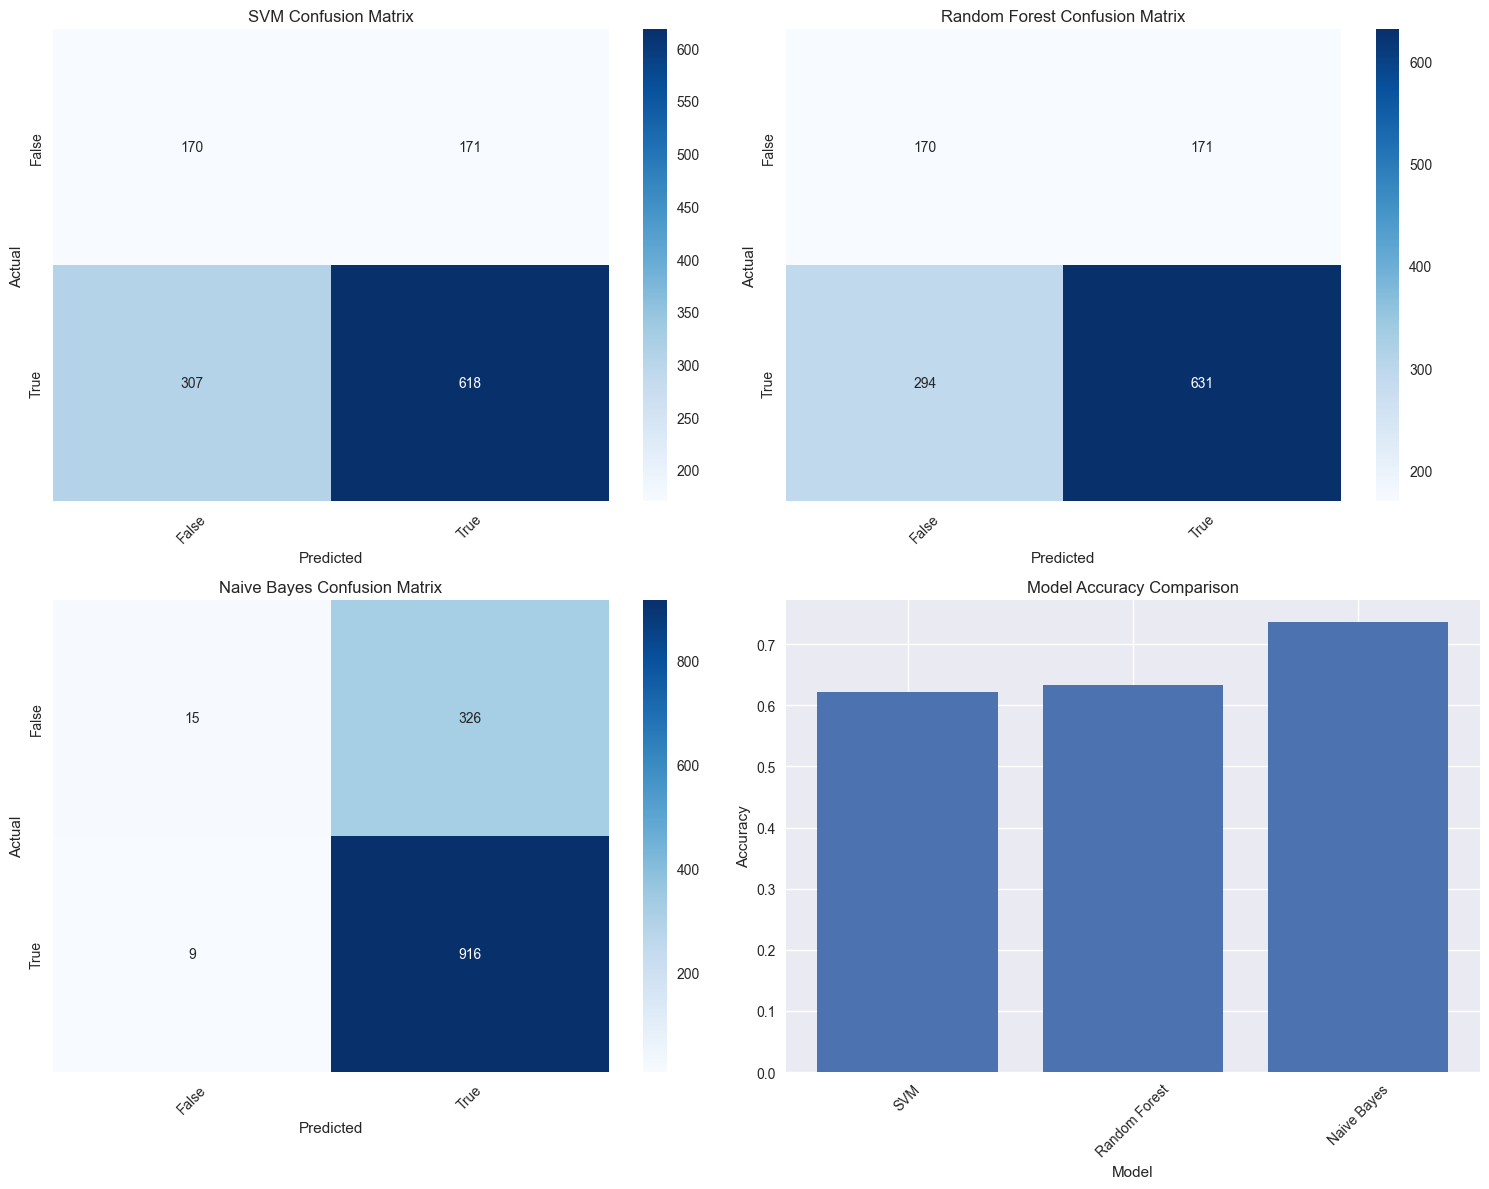


SVM:
Accuracy: 0.622

Classification Report:
              precision    recall  f1-score   support

       False       0.36      0.50      0.42       341
        True       0.78      0.67      0.72       925

    accuracy                           0.62      1266
   macro avg       0.57      0.58      0.57      1266
weighted avg       0.67      0.62      0.64      1266


Random Forest:
Accuracy: 0.633

Classification Report:
              precision    recall  f1-score   support

       False       0.37      0.50      0.42       341
        True       0.79      0.68      0.73       925

    accuracy                           0.63      1266
   macro avg       0.58      0.59      0.58      1266
weighted avg       0.67      0.63      0.65      1266


Naive Bayes:
Accuracy: 0.735

Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.04      0.08       341
        True       0.74      0.99      0.85       925

    accuracy              

In [31]:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (model_name, pred) in enumerate(predictions.items()):
    if idx < 3:
        plt.subplot(2, 2, idx+1)
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['False', 'True'],
                   yticklabels=['False', 'True'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)

accuracies = [accuracy_score(y_test, pred) for pred in predictions.values()]
plt.subplot(2, 2, 4)
plt.bar(predictions.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

for model_name, pred in predictions.items():
    accuracy = accuracy_score(y_test, pred)
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, pred, target_names=['False', 'True']))

In [32]:
import os
os.makedirs('models', exist_ok=True)

for model_name, model in models.items():
    filename = f'models/{model_name.lower().replace(" ", "_")}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved {model_name} to {filename}")

joblib.dump(tfidf, 'models/tfidf.joblib')
print("Saved TF-IDF vectorizer to models/tfidf.joblib")

Saved SVM to models/svm.pkl
Saved Random Forest to models/random_forest.pkl
Saved Naive Bayes to models/naive_bayes.pkl
Saved TF-IDF vectorizer to models/tfidf.joblib
